# Fully Connected Experiments on FashionMNIST with a standardized setup


## 1. Setup

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns

from copy import deepcopy
from IPython import display
from random import uniform
from semitorch import (
    MaxPlus, maxplus_parameters, nonmaxplus_parameters,
    MinPlus, minplus_parameters, nonminplus_parameters,
    SemiLog, semilog_parameters, nonsemilog_parameters,
    TropicalSGD,
)
from statistics import quantiles
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import trange

device = "cuda" if torch.cuda.is_available() else "cpu"

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.10.7
[Taichi] Starting on arch=cuda


### Load FashionMNIST data

In [2]:
batch_size = 256
num_workers = 8

transforms_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.286,), (0.353,)),
    ]
)

transforms_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.286,), (0.353,)),
    ]
)

fmnist_trainset = FashionMNIST(root=".", train=True, download=True, transform=transforms_train)
fmnist_testset = FashionMNIST(root=".", train=False, download=True, transform=transforms_test)

fmnist_trainloader = DataLoader(fmnist_trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
fmnist_testloader = DataLoader(fmnist_testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## 2. Models

In [3]:
class Model(nn.Module):
    def __init__(
            self,
            model_name: str,
            layer_norm: bool = False,
            skip_connections: bool = False,
            k: float = None,
            mu: float = None,
    ) -> None:
        super().__init__()
        self.name = model_name
        self.skip_connections = skip_connections

        self.stem = nn.Sequential(*list(filter(lambda layer: layer is not None, [
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=4, stride=4),
            nn.Flatten(),
            nn.LayerNorm(8 * 7 * 7) if layer_norm else None,
        ])))

        if model_name == "linear/relu":
            self.backbone_1 = nn.Sequential(
                nn.Linear(8 * 7 * 7, 300), nn.ReLU(),
                nn.Linear(300, 250), nn.ReLU(),
            )
            self.backbone_2 = nn.Sequential(
                nn.Linear(250 + (8 * 7 * 7 if self.skip_connections else 0), 200), nn.ReLU(),
                nn.Linear(200, 150), nn.ReLU(),
            )
            self.backbone_3 = nn.Sequential(
                nn.Linear(150 + (250 if self.skip_connections else 0), 100), nn.ReLU(),
                nn.Linear(100, 50), nn.ReLU(),
            )
        elif model_name == "linear/maxplus":
            self.backbone_1 = nn.Sequential(
                nn.Linear(8 * 7 * 7, 300),
                MaxPlus(300, 250, k=k),
            )
            self.backbone_2 = nn.Sequential(
                nn.Linear(250 + (8 * 7 * 7 if self.skip_connections else 0), 200),
                MaxPlus(200, 150, k=k),
            )
            self.backbone_3 = nn.Sequential(
                nn.Linear(150 + (250 if self.skip_connections else 0), 100),
                MaxPlus(100, 50, k=k),
            )
        elif model_name == "linear/minplus":
            self.backbone_1 = nn.Sequential(
                nn.Linear(8 * 7 * 7, 300),
                MinPlus(300, 250, k=k),
            )
            self.backbone_2 = nn.Sequential(
                nn.Linear(250 + (8 * 7 * 7 if self.skip_connections else 0), 200),
                MinPlus(200, 150, k=k),
            )
            self.backbone_3 = nn.Sequential(
                nn.Linear(150 + (250 if self.skip_connections else 0), 100),
                MinPlus(100, 50, k=k),
            )
        elif model_name == "linear/log":
            self.backbone_1 = nn.Sequential(
                nn.Linear(8 * 7 * 7, 300),
                SemiLog(300, 250, mu=mu),
            )
            self.backbone_2 = nn.Sequential(
                nn.Linear(250 + (8 * 7 * 7 if self.skip_connections else 0), 200),
                SemiLog(200, 150, mu=mu),
            )
            self.backbone_3 = nn.Sequential(
                nn.Linear(150 + (250 if self.skip_connections else 0), 100),
                SemiLog(100, 50, mu=mu),
            )
        else:
            raise RuntimeError(f"Unknown model ({model_name})")

        self.head = nn.Linear(50, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        input_0 = x
        result_0 = self.stem(input_0)

        input_1 = result_0
        result_1 = self.backbone_1(input_1)

        if self.skip_connections:
            input_2 = torch.cat((result_1, result_0), dim=-1)
        else:
            input_2 = result_1
        result_2 = self.backbone_2(input_2)

        if self.skip_connections:
            input_3 = torch.cat((result_2, result_1), dim=-1)
        else:
            input_3 = result_2
        result_3 = self.backbone_3(input_3)

        output = self.head(result_3)

        return output

In [4]:
def count_parameters(parameters) -> int:
    return sum(p.numel() for p in parameters if p.requires_grad)

## 3. Training

In [5]:
def accuracy(model: nn.Module, x: torch.Tensor, y: torch.Tensor) -> float:
    with torch.no_grad():
        yout = model(x)
        _, prediction = torch.max(yout.cpu(), dim=1)

        return (y.cpu() == prediction).sum().item() / float(y.numel())


def test(model: nn.Module, testloader: DataLoader) -> float:
    model.eval()
    accs = []

    with torch.no_grad():
        for x, y in testloader:
            x = x.to(device)
            accs.append(accuracy(model, x, y))

    return sum(accs) / len(accs)


def confusion_matrix(model: nn.Module, testloader: DataLoader) -> None:
    model.eval()

    conf_matrix = torch.zeros(len(fmnist_testset.classes), len(fmnist_testset.classes))

    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)

            conf_matrix[y.cpu(), prediction] += 1

    plt.figure(figsize=(6, 4))

    df_cm = pd.DataFrame(conf_matrix, index=fmnist_testset.classes, columns=fmnist_testset.classes).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def train(
        model: nn.Module,
        trainloader: DataLoader,
        testloader: DataLoader,
        optimizers: list[torch.optim.Optimizer],
        schedulers: list[torch.optim.lr_scheduler],
        loss: torch.nn.modules.loss,
        epochs: int,
        statistics_mode: bool = False  # If True: (return max acc and do not generate output)
) -> None | float:
    accs = []  # list of accuracy on the test dataset for every epoch
    trainaccs = []  # a list of the accuracies of all the training batches

    if not statistics_mode:
        fig, ax = plt.subplots(1, 1, figsize=[6, 4])
        hdisplay = display.display("", display_id=True)

    for _ in trange(epochs):
        model.train()

        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            for optimizer in optimizers:
                optimizer.zero_grad()
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)
            trainaccs.append((y.cpu() == prediction).sum().item() / float(y.numel()))

            l = loss(yout, y.squeeze())
            l.backward()
            for optimizer in optimizers:
                if isinstance(optimizer, TropicalSGD):
                    optimizer.step(input_tensor=x.cpu())
                else:
                    optimizer.step()

            for scheduler in schedulers:
                scheduler.step()

        accs.append(test(model, testloader))

        if not statistics_mode:
            ax.clear()
            ax.set_xlim(0, epochs)
            ax.set_ylim(-0.02, 1.02)
            ax.plot(
                np.linspace(0, len(accs), len(trainaccs)),
                trainaccs,
                ".",
                markersize=1.5,
                markerfacecolor=(0, 0, 1, 0.3),
            )
            ax.plot(np.linspace(1, len(accs), len(accs)), accs)
            ax.text(
                0.6 * epochs,
                0.30,
                f"max test acc = {max(accs):.2%}",
                ha="center",
                fontsize=10,
            )
            hdisplay.update(fig)

        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()

    if not statistics_mode:
        confusion_matrix(model, testloader)
        
    if statistics_mode:
        return max(accs)

In [6]:
def run_model_for_config(config: dict, best_accuracy: float) -> dict:
    loss = nn.CrossEntropyLoss()
    epochs = 20

    # Create model
    model_name = config["model_name"]
    layer_norm = config["layer_norm"]
    skip_connections = config["skip_connections"]
    k = config["k"]
    mu = config["mu"]

    model = Model(model_name=model_name, layer_norm=layer_norm, skip_connections=skip_connections, k=k, mu=mu).to(
        device)

    # Separate model parameters
    if model_name == "linear/relu":
        linear_params = model.parameters()
        semiring_params = nn.ParameterList()
    elif model_name == "linear/maxplus":
        linear_params = nonmaxplus_parameters(model)
        semiring_params = maxplus_parameters(model)
    elif model_name == "linear/minplus":
        linear_params = nonminplus_parameters(model)
        semiring_params = minplus_parameters(model)
    elif model_name == "linear/log":
        linear_params = nonsemilog_parameters(model)
        semiring_params = semilog_parameters(model)
    else:
        raise RuntimeError(f"Unknown model ({model_name})")

    # Create linear optimizer
    linear_lr = config["linear_lr"]
    if config["linear_optimizer"] == "AdamW":
        linear_optimizer = torch.optim.AdamW(linear_params, lr=linear_lr)
    elif config["linear_optimizer"] == "SGD":
        linear_optimizer = torch.optim.SGD(linear_params, lr=linear_lr)
    else:
        raise RuntimeError(f'Unknown linear optimizer {config["linear_optimizer"]}')
    if config["linear_scheduler"]:
        linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            linear_optimizer,
            max_lr=linear_lr,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(fmnist_trainloader),
            epochs=epochs,
        )
    else:
        linear_scheduler = None

    # Create semiring optimizer
    semiring_lr = config["semiring_lr"]
    if config["semiring_optimizer"] is None:
        semiring_optimizer = None
    elif config["semiring_optimizer"] == "AdamW":
        semiring_optimizer = torch.optim.AdamW(semiring_params, lr=semiring_lr)
    elif config["semiring_optimizer"] == "SGD":
        semiring_optimizer = torch.optim.SGD(semiring_params, lr=semiring_lr)
    elif config["semiring_optimizer"] == "TropicalSGD":
        semiring_optimizer = TropicalSGD(semiring_params, lr=semiring_lr)
    else:
        raise RuntimeError(f'Unknown semiring optimizer {config["semiring_optimizer"]}')
    if config["semiring_scheduler"]:
        semiring_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            semiring_optimizer,
            max_lr=semiring_lr,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(fmnist_trainloader),
            epochs=epochs,
        )
    else:
        semiring_scheduler = None

    # Create optimizers and schedulers
    optimizers = list(filter(lambda opt: opt is not None, [linear_optimizer, semiring_optimizer]))
    schedulers = list(filter(lambda sch: sch is not None, [linear_scheduler, semiring_scheduler]))

    report, reported_accuracy, last_reported_accuracy = [], 0, 0
    for epoch in range(epochs):
        last_reported_accuracy = reported_accuracy

        # Feed to training function
        reported_accuracy = train_model(
            model,
            fmnist_trainloader,
            fmnist_testloader,
            optimizers,
            schedulers,
            loss,
        )

        # Try some stopping conditions
        if ((epoch > 2) and (reported_accuracy < 0.15)) or ((epoch > 5) and (reported_accuracy < best_accuracy / 2)):
            # Bad trial
            return {"accuracy": reported_accuracy, "config": config}

        if (epoch > 2) and (abs(last_reported_accuracy - reported_accuracy) < 1e-6):
            # Run is done, no sense to train it any further
            break  # Break for-loop to report

    return {"accuracy": reported_accuracy, "config": config}


def train_model(
        model: nn.Module,
        trainloader: DataLoader,
        testloader: DataLoader,
        optimizers: list[torch.optim.Optimizer],
        schedulers: list[torch.optim.lr_scheduler],
        loss: torch.nn.modules.loss,
) -> float:
    model.train()

    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        for optimizer in optimizers:
            optimizer.zero_grad()

        l = loss(model(x), y.squeeze())
        l.backward()

        for optimizer in optimizers:
            if isinstance(optimizer, TropicalSGD):
                optimizer.step(input_tensor=x.cpu())
            else:
                optimizer.step()

        for scheduler in schedulers:
            scheduler.step()

        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()

    return test(model, testloader)


def run_random_search_for_config(config: dict) -> dict:
    best_accuracy, best_config, current_config = 0, deepcopy(config), deepcopy(config)
    step_size, bad_step_counter, good_step_counter = 0.1, 0, 0
    for num_trial in range(100):
        result = run_model_for_config(current_config, best_accuracy=best_accuracy)

        if result["accuracy"] > best_accuracy:
            bad_step_counter = 0
            good_step_counter += 1

            best_accuracy, best_config = result["accuracy"], deepcopy(current_config)
        else:
            bad_step_counter += 1
            good_step_counter = 0

        if bad_step_counter > 10:
            break  # Terminate run, likely no better accuracy possible

        current_config, step_size, bad_step_counter, good_step_counter = adaptive_step_update_config(
            config=deepcopy(best_config),
            step_size=step_size,
            bad_step_counter=bad_step_counter,
            good_step_counter=good_step_counter,
        )

        if step_size < 1e-2:
            # Step size too small to make any impact, terminate run
            break

    return {"accuracy": best_accuracy, "config": best_config}


def adaptive_step_update_config(
        config: dict,
        step_size: float,
        bad_step_counter: int,
        good_step_counter: int,
) -> tuple[dict, float, int, int]:
    # Update step_size
    if bad_step_counter > 2:
        step_size /= 2
        bad_step_counter = 0
    if (good_step_counter > 2) and (step_size < 0.5):
        step_size *= 2
        good_step_counter = 0

    # Update config values
    if config["model_name"] == "linear/relu":
        config["linear_lr"] = uniform(
            config["linear_lr"] * (1 - step_size),
            config["linear_lr"] * (1 + step_size),
        )
    if config["model_name"] in ["linear/maxplus", "linear/minplus"]:
        config["k"] = uniform(
            config["k"] * (1 - step_size),
            config["k"] * (1 + step_size),
        )
    if config["model_name"] != "linear/relu":
        config["semiring_lr"] = uniform(
            config["semiring_lr"] * (1 - step_size),
            config["semiring_lr"] * (1 + step_size),
        )
    if config["model_name"] == "linear/log":
        config["mu"] = uniform(
            config["mu"] * (1 - step_size),
            config["mu"] * (1 + step_size),
        )

    return config, step_size, bad_step_counter, good_step_counter


def find_best_model_for(config: dict) -> None:
    current_config, results = deepcopy(config), []

    if config["model_name"] == "linear/relu":
        for linear_optimizer in config["linear_optimizer"]:
            current_config["linear_optimizer"] = linear_optimizer
            for linear_scheduler in config["linear_scheduler"]:
                current_config["linear_scheduler"] = linear_scheduler

                print(f"Starting linear run for config {current_config}")
                results.append(run_random_search_for_config(current_config))
    else:
        for semiring_optimizer in config["semiring_optimizer"]:
            current_config["semiring_optimizer"] = semiring_optimizer
            if semiring_optimizer == "TropicalSGD":
                # TropicalSGD does not support momentum and cycle-momentum
                # Both are necessary for one-cycle scheduler
                print(f"Starting semiring run for config {current_config}")
                results.append(run_random_search_for_config(current_config))
            else:
                for semiring_scheduler in config["semiring_scheduler"]:
                    current_config["semiring_scheduler"] = semiring_scheduler

                    print(f"Starting semiring run for config {current_config}")
                    results.append(run_random_search_for_config(current_config))

    sorted_results = sorted(results, key=lambda dictionary: dictionary["accuracy"], reverse=True)

    display.clear_output(wait=True)
    print(f'Best trial config with accuracy of {sorted_results[0]["accuracy"]}: {sorted_results[0]["config"]}')
    print(f"-----------------")
    print(*sorted_results, sep="\n")

# Default Linear Models

In [7]:
find_best_model_for(config={
    "model_name": "linear/relu",
    "layer_norm": True,
    "skip_connections": True,
    "k": None,
    "linear_optimizer": ["AdamW", "SGD"],
    "linear_scheduler": [True, False],
    "linear_lr": 10 ** uniform(-3, -1),
    "semiring_lr": None,
    "semiring_optimizer": None,
    "semiring_scheduler": None,
    "mu": None,
})

Best trial config with accuracy of 0.89921875: {'model_name': 'linear/relu', 'layer_norm': True, 'skip_connections': True, 'k': None, 'linear_optimizer': 'SGD', 'linear_scheduler': True, 'linear_lr': 0.05971752653541055, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None, 'mu': None}
-----------------
{'accuracy': 0.89921875, 'config': {'model_name': 'linear/relu', 'layer_norm': True, 'skip_connections': True, 'k': None, 'linear_optimizer': 'SGD', 'linear_scheduler': True, 'linear_lr': 0.05971752653541055, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None, 'mu': None}}
{'accuracy': 0.88173828125, 'config': {'model_name': 'linear/relu', 'layer_norm': True, 'skip_connections': True, 'k': None, 'linear_optimizer': 'SGD', 'linear_scheduler': False, 'linear_lr': 0.06000084767438664, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None, 'mu': None}}
{'accuracy': 0.09931640625, 'config': {'model_name': 'linear/relu', 'l

In [8]:
find_best_model_for(config={
    "model_name": "linear/relu",
    "layer_norm": True,
    "skip_connections": False,
    "k": None,
    "linear_optimizer": ["AdamW", "SGD"],
    "linear_scheduler": [True, False],
    "linear_lr": 10 ** uniform(-3, -1),
    "semiring_lr": None,
    "semiring_optimizer": None,
    "semiring_scheduler": None,
    "mu": None,
})

Best trial config with accuracy of 0.89609375: {'model_name': 'linear/relu', 'layer_norm': True, 'skip_connections': False, 'k': None, 'linear_optimizer': 'SGD', 'linear_scheduler': True, 'linear_lr': 0.03354577137468155, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None, 'mu': None}
-----------------
{'accuracy': 0.89609375, 'config': {'model_name': 'linear/relu', 'layer_norm': True, 'skip_connections': False, 'k': None, 'linear_optimizer': 'SGD', 'linear_scheduler': True, 'linear_lr': 0.03354577137468155, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None, 'mu': None}}
{'accuracy': 0.87412109375, 'config': {'model_name': 'linear/relu', 'layer_norm': True, 'skip_connections': False, 'k': None, 'linear_optimizer': 'SGD', 'linear_scheduler': False, 'linear_lr': 0.03835297415554376, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None, 'mu': None}}
{'accuracy': 0.1005859375, 'config': {'model_name': 'linear/relu', 

In [7]:
find_best_model_for(config={
    "model_name": "linear/relu",
    "layer_norm": False,
    "skip_connections": True,
    "k": None,
    "linear_optimizer": ["AdamW", "SGD"],
    "linear_scheduler": [True, False],
    "linear_lr": 10 ** uniform(-3, -1),
    "semiring_lr": None,
    "semiring_optimizer": None,
    "semiring_scheduler": None,
    "mu": None,
})

Best trial config with accuracy of 0.8990234375: {'model_name': 'linear/relu', 'layer_norm': False, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.007762420362152599, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None, 'mu': None}
-----------------
{'accuracy': 0.8990234375, 'config': {'model_name': 'linear/relu', 'layer_norm': False, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.007762420362152599, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None, 'mu': None}}
{'accuracy': 0.88740234375, 'config': {'model_name': 'linear/relu', 'layer_norm': False, 'skip_connections': True, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': False, 'linear_lr': 0.007287032211674688, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None, 'mu': None}}
{'accuracy': 0.88603515625, 'config': {'model_name': '

In [7]:
find_best_model_for(config={
    "model_name": "linear/relu",
    "layer_norm": False,
    "skip_connections": False,
    "k": None,
    "linear_optimizer": ["AdamW", "SGD"],
    "linear_scheduler": [True, False],
    "linear_lr": 10 ** uniform(-3, -1),
    "semiring_lr": None,
    "semiring_optimizer": None,
    "semiring_scheduler": None,
    "mu": None,
})

Best trial config with accuracy of 0.89599609375: {'model_name': 'linear/relu', 'layer_norm': False, 'skip_connections': False, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.0031251852421539513, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None, 'mu': None}
-----------------
{'accuracy': 0.89599609375, 'config': {'model_name': 'linear/relu', 'layer_norm': False, 'skip_connections': False, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.0031251852421539513, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None, 'mu': None}}
{'accuracy': 0.89248046875, 'config': {'model_name': 'linear/relu', 'layer_norm': False, 'skip_connections': False, 'k': None, 'linear_optimizer': 'AdamW', 'linear_scheduler': False, 'linear_lr': 0.002888360604567611, 'semiring_lr': None, 'semiring_optimizer': None, 'semiring_scheduler': None, 'mu': None}}
{'accuracy': 0.74658203125, 'config': {'model_n

In [7]:
# Return best linear hyperparams, optimiser and scheduler for config
def get_linear_info(layer_norm: bool, skip_connections: bool) -> (float, str, bool):
    """
    Using SGD for linear parameters in semiring models does not work.
    Se will pick best performing AdamW linear config.
    """
    
    if layer_norm and skip_connections:
        # 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.059873835854729544
        return 0.059873835854729544, 'AdamW', True
    elif layer_norm and not skip_connections:
        # 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.03640717628614364
        return 0.03640717628614364, 'AdamW', True
    elif not layer_norm and skip_connections:
        # 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.007762420362152599
        return 0.007762420362152599, 'AdamW', True
    elif not layer_norm and not skip_connections:
        # 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.0031251852421539513
        return 0.0031251852421539513, 'AdamW', True
    else:
        raise RuntimeError("This case should not exist")
        

Best linear model

linear/relu model has 398470 trainable parameters


''

  0%|          | 0/20 [00:00<?, ?it/s]

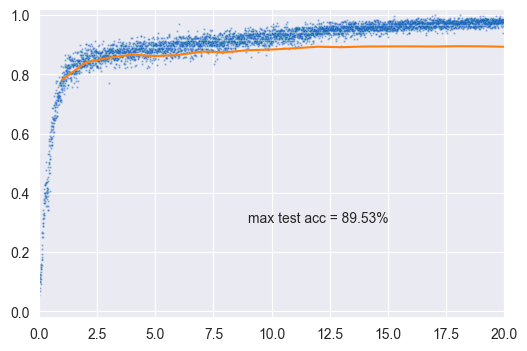

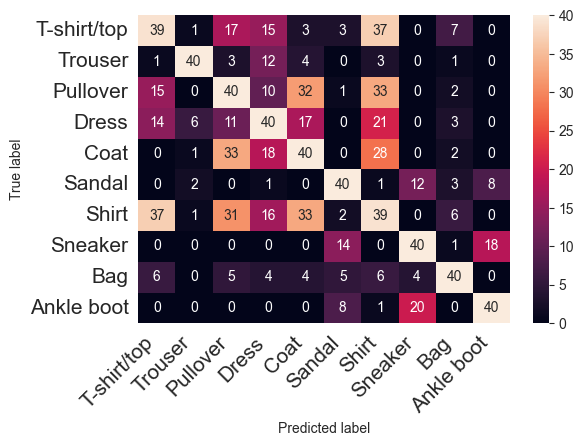

In [9]:
best_linear_model = Model(model_name="linear/relu", layer_norm=True, skip_connections=True).to(device)
print(f"{best_linear_model.name} model has {count_parameters(best_linear_model.parameters())} trainable parameters")

best_linear_optimizer = torch.optim.SGD(best_linear_model.parameters(), lr=0.05971752653541055)
best_linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    best_linear_optimizer,
    max_lr=0.05971752653541055,
    anneal_strategy="linear",
    pct_start=0.3,
    three_phase=True,
    final_div_factor=1000.0,
    div_factor=10.0,
    steps_per_epoch=len(fmnist_trainloader),
    epochs=20,
)

train(
    best_linear_model,
    fmnist_trainloader,
    fmnist_testloader,
    [best_linear_optimizer],
    [best_linear_scheduler],
    nn.CrossEntropyLoss(),
    20,
)

In [ ]:
best_linear_model_accs = []
for i in range(100):
    print(i)
    
    best_linear_model = Model(model_name="linear/relu", layer_norm=True, skip_connections=True).to(device)
    
    best_linear_optimizer = torch.optim.SGD(best_linear_model.parameters(), lr=0.05971752653541055)
    best_linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        best_linear_optimizer,
        max_lr=0.05971752653541055,
        anneal_strategy="linear",
        pct_start=0.3,
        three_phase=True,
        final_div_factor=1000.0,
        div_factor=10.0,
        steps_per_epoch=len(fmnist_trainloader),
        epochs=20,
    )
    
    best_linear_model_accs.append(train(
        best_linear_model,
        fmnist_trainloader,
        fmnist_testloader,
        [best_linear_optimizer],
        [best_linear_scheduler],
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))
    
    display.clear_output(wait=True)

print(min(best_linear_model_accs))
print(quantiles(best_linear_model_accs))
print(max(best_linear_model_accs))

# Tropical models

MaxPlus

In [8]:
linear_lr, linear_optimizer, linear_scheduler = get_linear_info(layer_norm=True, skip_connections=False)

find_best_model_for(config={
    "model_name": "linear/maxplus",
    "layer_norm": True,
    "skip_connections": False,
    "k": uniform(1, 3),
    "linear_optimizer": linear_optimizer,
    "linear_scheduler": linear_scheduler,
    "linear_lr": linear_lr,
    "semiring_lr": 10 ** uniform(-3, -2),
    "semiring_optimizer": ["AdamW", "SGD", "TropicalSGD"],
    "semiring_scheduler": [True, False],
    "mu": None,
})

Best trial config with accuracy of 0.72119140625: {'model_name': 'linear/maxplus', 'layer_norm': True, 'skip_connections': False, 'k': 1.0997403061750572, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.03640717628614364, 'semiring_lr': 0.0023108169711231023, 'semiring_optimizer': 'AdamW', 'semiring_scheduler': False, 'mu': None}
-----------------
{'accuracy': 0.72119140625, 'config': {'model_name': 'linear/maxplus', 'layer_norm': True, 'skip_connections': False, 'k': 1.0997403061750572, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.03640717628614364, 'semiring_lr': 0.0023108169711231023, 'semiring_optimizer': 'AdamW', 'semiring_scheduler': False, 'mu': None}}
{'accuracy': 0.51689453125, 'config': {'model_name': 'linear/maxplus', 'layer_norm': True, 'skip_connections': False, 'k': 1.0309792647702296, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.03640717628614364, 'semiring_lr': 0.002215844155625672, 'semiring_optimi

In [11]:
linear_lr, linear_optimizer, linear_scheduler = get_linear_info(layer_norm=False, skip_connections=False)

find_best_model_for(config={
    "model_name": "linear/maxplus",
    "layer_norm": False,
    "skip_connections": False,
    "k": uniform(1, 3),
    "linear_optimizer": linear_optimizer,
    "linear_scheduler": linear_scheduler,
    "linear_lr": linear_lr,
    "semiring_lr": 10 ** uniform(-3, -2),
    "semiring_optimizer": ["AdamW", "SGD", "TropicalSGD"],
    "semiring_scheduler": [True, False],
    "mu": None,
})

Best trial config with accuracy of 0.8876953125: {'model_name': 'linear/maxplus', 'layer_norm': False, 'skip_connections': False, 'k': 2.256427031094938, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.0031251852421539513, 'semiring_lr': 0.002433015507337236, 'semiring_optimizer': 'AdamW', 'semiring_scheduler': False, 'mu': None}
-----------------
{'accuracy': 0.8876953125, 'config': {'model_name': 'linear/maxplus', 'layer_norm': False, 'skip_connections': False, 'k': 2.256427031094938, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.0031251852421539513, 'semiring_lr': 0.002433015507337236, 'semiring_optimizer': 'AdamW', 'semiring_scheduler': False, 'mu': None}}
{'accuracy': 0.8853515625, 'config': {'model_name': 'linear/maxplus', 'layer_norm': False, 'skip_connections': False, 'k': 2.2220299425190944, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.0031251852421539513, 'semiring_lr': 0.00244281604406467, 'semiring_optim

In [11]:
linear_lr, linear_optimizer, linear_scheduler = get_linear_info(layer_norm=True, skip_connections=True)

find_best_model_for(config={
    "model_name": "linear/maxplus",
    "layer_norm": True,
    "skip_connections": True,
    "k": uniform(1, 3),
    "linear_optimizer": linear_optimizer,
    "linear_scheduler": linear_scheduler,
    "linear_lr": linear_lr,
    "semiring_lr": 10 ** uniform(-3, -2),
    "semiring_optimizer": ["AdamW", "SGD", "TropicalSGD"],
    "semiring_scheduler": [True, False],
    "mu": None,
})

Best trial config with accuracy of 0.54189453125: {'model_name': 'linear/maxplus', 'layer_norm': True, 'skip_connections': True, 'k': 1.2652949558522781, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.059873835854729544, 'semiring_lr': 0.0025426946902122006, 'semiring_optimizer': 'AdamW', 'semiring_scheduler': False, 'mu': None}
-----------------
{'accuracy': 0.54189453125, 'config': {'model_name': 'linear/maxplus', 'layer_norm': True, 'skip_connections': True, 'k': 1.2652949558522781, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.059873835854729544, 'semiring_lr': 0.0025426946902122006, 'semiring_optimizer': 'AdamW', 'semiring_scheduler': False, 'mu': None}}
{'accuracy': 0.50517578125, 'config': {'model_name': 'linear/maxplus', 'layer_norm': True, 'skip_connections': True, 'k': 1.288764041440372, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.059873835854729544, 'semiring_lr': 0.002439130914882788, 'semiring_optimiz

In [9]:
linear_lr, linear_optimizer, linear_scheduler = get_linear_info(layer_norm=False, skip_connections=True)

find_best_model_for(config={
    "model_name": "linear/maxplus",
    "layer_norm": False,
    "skip_connections": True,
    "k": uniform(1, 3),
    "linear_optimizer": linear_optimizer,
    "linear_scheduler": linear_scheduler,
    "linear_lr": linear_lr,
    "semiring_lr": 10 ** uniform(-3, -2),
    "semiring_optimizer": ["AdamW", "SGD", "TropicalSGD"],
    "semiring_scheduler": [True, False],
    "mu": None,
})

Best trial config with accuracy of 0.88681640625: {'model_name': 'linear/maxplus', 'layer_norm': False, 'skip_connections': True, 'k': 3.036865953332137, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.007762420362152599, 'semiring_lr': 0.007683624419514911, 'semiring_optimizer': 'AdamW', 'semiring_scheduler': False, 'mu': None}
-----------------
{'accuracy': 0.88681640625, 'config': {'model_name': 'linear/maxplus', 'layer_norm': False, 'skip_connections': True, 'k': 3.036865953332137, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.007762420362152599, 'semiring_lr': 0.007683624419514911, 'semiring_optimizer': 'AdamW', 'semiring_scheduler': False, 'mu': None}}
{'accuracy': 0.88515625, 'config': {'model_name': 'linear/maxplus', 'layer_norm': False, 'skip_connections': True, 'k': 2.390796766202493, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.007762420362152599, 'semiring_lr': 0.00894457763563847, 'semiring_optimizer': 

Best MaxPlus model

linear/maxplus model has 294286 trainable parameters, of which 183836 are linear and 110450 are semiring related


''

  0%|          | 0/20 [00:00<?, ?it/s]

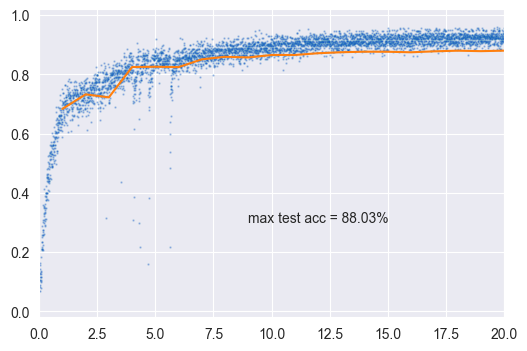

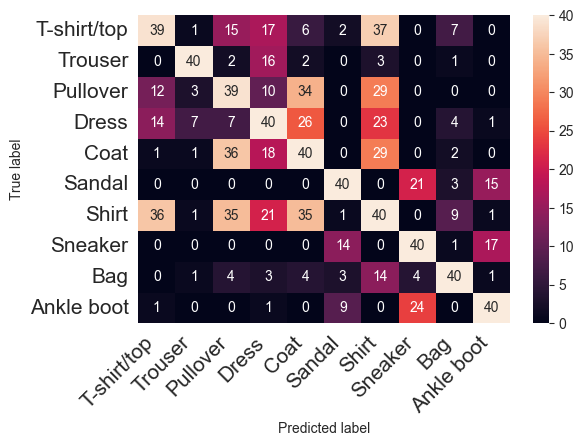

In [16]:
best_maxplus_model = Model("linear/maxplus", layer_norm=False, skip_connections=False, k=2.256427031094938).to(device)

print(f"{best_maxplus_model.name} model has {count_parameters(best_maxplus_model.parameters())} trainable parameters, "
      f"of which {count_parameters(nonmaxplus_parameters(best_maxplus_model))} are linear "
      f"and {count_parameters(maxplus_parameters(best_maxplus_model))} are semiring related")

best_maxplus_linear_optimizer = torch.optim.AdamW(nonmaxplus_parameters(best_maxplus_model), lr=0.0031251852421539513)
best_maxplus_linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    best_maxplus_linear_optimizer,
    max_lr=0.0031251852421539513,
    anneal_strategy="linear",
    pct_start=0.3,
    three_phase=True,
    final_div_factor=1000.0,
    div_factor=10.0,
    steps_per_epoch=len(fmnist_trainloader),
    epochs=20,
)
best_maxplus_semiring_optimizer = torch.optim.AdamW(maxplus_parameters(best_maxplus_model), lr=0.002433015507337236)

best_maxplus_optimizers = [best_maxplus_linear_optimizer, best_maxplus_semiring_optimizer]
best_maxplus_schedulers = [best_maxplus_linear_scheduler]

train(
    best_maxplus_model,
    fmnist_trainloader,
    fmnist_testloader,
    best_maxplus_optimizers,
    best_maxplus_schedulers,
    nn.CrossEntropyLoss(),
    20,
)

In [14]:
best_maxplus_model_accs = []
for i in range(100):
    print(i)
    
    best_maxplus_model = Model("linear/maxplus", layer_norm=False, skip_connections=False, k=2.6196357564250334).to(device)

    best_maxplus_linear_optimizer = torch.optim.AdamW(nonmaxplus_parameters(best_maxplus_model), lr=0.0031251852421539513)
    best_maxplus_linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        best_maxplus_linear_optimizer,
        max_lr=0.0031251852421539513,
        anneal_strategy="linear",
        pct_start=0.3,
        three_phase=True,
        final_div_factor=1000.0,
        div_factor=10.0,
        steps_per_epoch=len(fmnist_trainloader),
        epochs=20,
    )
    best_maxplus_semiring_optimizer = torch.optim.AdamW(maxplus_parameters(best_maxplus_model), lr=0.002433015507337236)
    
    best_maxplus_optimizers = [best_maxplus_linear_optimizer, best_maxplus_semiring_optimizer]
    best_maxplus_schedulers = [best_maxplus_linear_scheduler]
    
    best_maxplus_model_accs.append(train(
        best_maxplus_model,
        fmnist_trainloader,
        fmnist_testloader,
        best_maxplus_optimizers,
        best_maxplus_schedulers,
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))
    
    display.clear_output(wait=True)
    
print(min(best_maxplus_model_accs))
print(quantiles(best_maxplus_model_accs))
print(max(best_maxplus_model_accs))

0.84423828125
[0.8794189453125, 0.8819824218750001, 0.8854248046875001]
0.8904296875


MinPlus

In [12]:
linear_lr, linear_optimizer, linear_scheduler = get_linear_info(layer_norm=True, skip_connections=False)

find_best_model_for(config={
    "model_name": "linear/minplus",
    "layer_norm": True,
    "skip_connections": False,
    "k": uniform(1, 3),
    "linear_optimizer": linear_optimizer,
    "linear_scheduler": linear_scheduler,
    "linear_lr": linear_lr,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["AdamW", "SGD", "TropicalSGD"],
    "semiring_scheduler": [True, False],
    "mu": None,
})

Best trial config with accuracy of 0.60341796875: {'model_name': 'linear/minplus', 'layer_norm': True, 'skip_connections': False, 'k': 1.799905311505003, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.03640717628614364, 'semiring_lr': 0.0027996026409390033, 'semiring_optimizer': 'AdamW', 'semiring_scheduler': True, 'mu': None}
-----------------
{'accuracy': 0.60341796875, 'config': {'model_name': 'linear/minplus', 'layer_norm': True, 'skip_connections': False, 'k': 1.799905311505003, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.03640717628614364, 'semiring_lr': 0.0027996026409390033, 'semiring_optimizer': 'AdamW', 'semiring_scheduler': True, 'mu': None}}
{'accuracy': 0.4818359375, 'config': {'model_name': 'linear/minplus', 'layer_norm': True, 'skip_connections': False, 'k': 1.6455179683863488, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.03640717628614364, 'semiring_lr': 0.0027045828000704262, 'semiring_optimizer'

In [10]:
linear_lr, linear_optimizer, linear_scheduler = get_linear_info(layer_norm=False, skip_connections=False)

find_best_model_for(config={
    "model_name": "linear/minplus",
    "layer_norm": False,
    "skip_connections": False,
    "k": uniform(1, 3),
    "linear_optimizer": linear_optimizer,
    "linear_scheduler": linear_scheduler,
    "linear_lr": linear_lr,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["AdamW", "SGD", "TropicalSGD"],
    "semiring_scheduler": [True, False],
    "mu": None,
})

Best trial config with accuracy of 0.88876953125: {'model_name': 'linear/minplus', 'layer_norm': False, 'skip_connections': False, 'k': 2.746123627581554, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.0031251852421539513, 'semiring_lr': 0.0025919037802080752, 'semiring_optimizer': 'AdamW', 'semiring_scheduler': False, 'mu': None}
-----------------
{'accuracy': 0.88876953125, 'config': {'model_name': 'linear/minplus', 'layer_norm': False, 'skip_connections': False, 'k': 2.746123627581554, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.0031251852421539513, 'semiring_lr': 0.0025919037802080752, 'semiring_optimizer': 'AdamW', 'semiring_scheduler': False, 'mu': None}}
{'accuracy': 0.88740234375, 'config': {'model_name': 'linear/minplus', 'layer_norm': False, 'skip_connections': False, 'k': 2.4205515556583856, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.0031251852421539513, 'semiring_lr': 0.002765388406754773, 'semiring

In [8]:
linear_lr, linear_optimizer, linear_scheduler = get_linear_info(layer_norm=True, skip_connections=True)

find_best_model_for(config={
    "model_name": "linear/minplus",
    "layer_norm": True,
    "skip_connections": True,
    "k": uniform(1, 3),
    "linear_optimizer": linear_optimizer,
    "linear_scheduler": linear_scheduler,
    "linear_lr": linear_lr,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["AdamW", "SGD", "TropicalSGD"],
    "semiring_scheduler": [True, False],
    "mu": None,
})

Best trial config with accuracy of 0.65556640625: {'model_name': 'linear/minplus', 'layer_norm': True, 'skip_connections': True, 'k': 1.794180972974409, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.059873835854729544, 'semiring_lr': 0.0050116062367652064, 'semiring_optimizer': 'AdamW', 'semiring_scheduler': False, 'mu': None}
-----------------
{'accuracy': 0.65556640625, 'config': {'model_name': 'linear/minplus', 'layer_norm': True, 'skip_connections': True, 'k': 1.794180972974409, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.059873835854729544, 'semiring_lr': 0.0050116062367652064, 'semiring_optimizer': 'AdamW', 'semiring_scheduler': False, 'mu': None}}
{'accuracy': 0.6392578125, 'config': {'model_name': 'linear/minplus', 'layer_norm': True, 'skip_connections': True, 'k': 1.7428433645650336, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.059873835854729544, 'semiring_lr': 0.0045212689521415715, 'semiring_optimize

In [10]:
linear_lr, linear_optimizer, linear_scheduler = get_linear_info(layer_norm=False, skip_connections=True)

find_best_model_for(config={
    "model_name": "linear/minplus",
    "layer_norm": False,
    "skip_connections": True,
    "k": uniform(1, 3),
    "linear_optimizer": linear_optimizer,
    "linear_scheduler": linear_scheduler,
    "linear_lr": linear_lr,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["AdamW", "SGD", "TropicalSGD"],
    "semiring_scheduler": [True, False],
    "mu": None,
})

Best trial config with accuracy of 0.8734375: {'model_name': 'linear/minplus', 'layer_norm': False, 'skip_connections': True, 'k': 1.0548205908834332, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.007762420362152599, 'semiring_lr': 0.0045690495898574, 'semiring_optimizer': 'AdamW', 'semiring_scheduler': False, 'mu': None}
-----------------
{'accuracy': 0.8734375, 'config': {'model_name': 'linear/minplus', 'layer_norm': False, 'skip_connections': True, 'k': 1.0548205908834332, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.007762420362152599, 'semiring_lr': 0.0045690495898574, 'semiring_optimizer': 'AdamW', 'semiring_scheduler': False, 'mu': None}}
{'accuracy': 0.85087890625, 'config': {'model_name': 'linear/minplus', 'layer_norm': False, 'skip_connections': True, 'k': 1.0551299104164866, 'linear_optimizer': 'AdamW', 'linear_scheduler': True, 'linear_lr': 0.007762420362152599, 'semiring_lr': 0.004518505279847813, 'semiring_optimizer': 'Adam

Best MinPlus model

linear/minplus model has 294286 trainable parameters, of which 183836 are linear and 110450 are semiring related


''

  0%|          | 0/20 [00:00<?, ?it/s]

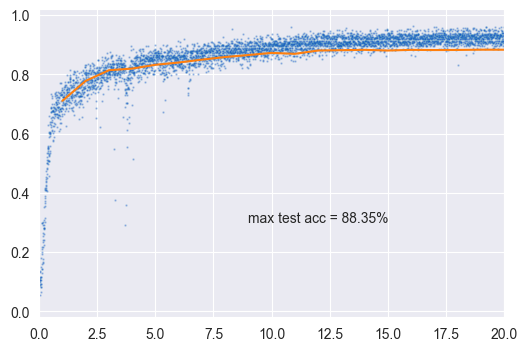

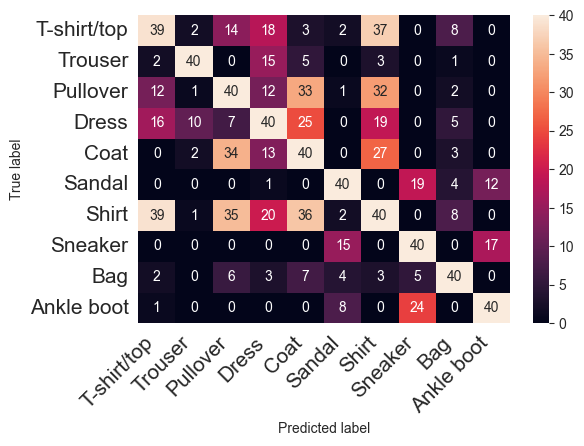

In [13]:
best_minplus_model = Model("linear/minplus", layer_norm=False, skip_connections=False, k=2.746123627581554).to(device)

print(f"{best_minplus_model.name} model has {count_parameters(best_minplus_model.parameters())} trainable parameters, "
      f"of which {count_parameters(nonminplus_parameters(best_minplus_model))} are linear "
      f"and {count_parameters(minplus_parameters(best_minplus_model))} are semiring related")

best_minplus_linear_optimizer = torch.optim.AdamW(nonminplus_parameters(best_minplus_model), lr=0.0031251852421539513)
best_minplus_linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    best_minplus_linear_optimizer,
    max_lr=0.0031251852421539513,
    anneal_strategy="linear",
    pct_start=0.3,
    three_phase=True,
    final_div_factor=1000.0,
    div_factor=10.0,
    steps_per_epoch=len(fmnist_trainloader),
    epochs=20,
)
best_minplus_semiring_optimizer = torch.optim.AdamW(minplus_parameters(best_minplus_model), lr=0.0025919037802080752)

best_minplus_optimizers = [best_minplus_linear_optimizer, best_minplus_semiring_optimizer]
best_minplus_schedulers = [best_minplus_linear_scheduler]

train(
    best_minplus_model,
    fmnist_trainloader,
    fmnist_testloader,
    best_minplus_optimizers,
    best_minplus_schedulers,
    nn.CrossEntropyLoss(),
    20,
)

In [ ]:
best_minplus_model_accs = []
for i in range(100):
    print(i)
    
    best_minplus_model = Model("linear/minplus", layer_norm=False, skip_connections=False, k=2.746123627581554).to(device)

    best_minplus_linear_optimizer = torch.optim.AdamW(nonminplus_parameters(best_minplus_model), lr=0.0031251852421539513)
    best_minplus_linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        best_minplus_linear_optimizer,
        max_lr=0.0031251852421539513,
        anneal_strategy="linear",
        pct_start=0.3,
        three_phase=True,
        final_div_factor=1000.0,
        div_factor=10.0,
        steps_per_epoch=len(fmnist_trainloader),
        epochs=20,
    )
    best_minplus_semiring_optimizer = torch.optim.AdamW(minplus_parameters(best_minplus_model), lr=0.0025919037802080752)
    
    best_minplus_optimizers = [best_minplus_linear_optimizer, best_minplus_semiring_optimizer]
    best_minplus_schedulers = [best_minplus_linear_scheduler]
    
    best_minplus_model_accs.append(train(
        best_minplus_model,
        fmnist_trainloader,
        fmnist_testloader,
        best_minplus_optimizers,
        best_minplus_schedulers,
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))
    
    display.clear_output(wait=True)
    
print(min(best_minplus_model_accs))
print(quantiles(best_minplus_model_accs))
print(max(best_minplus_model_accs))

Log semiring

In [ ]:
linear_lr, linear_optimizer, linear_scheduler = get_linear_info(layer_norm=True, skip_connections=False)

find_best_model_for(config={
    "model_name": "linear/log",
    "layer_norm": True,
    "skip_connections": False,
    "k": 5 * uniform(1, 3),
    "linear_optimizer": linear_optimizer,
    "linear_scheduler": linear_scheduler,
    "linear_lr": linear_lr,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["AdamW", "SGD"],
    "semiring_scheduler": [True, False],
    "mu": 1.0,
})

In [ ]:
linear_lr, linear_optimizer, linear_scheduler = get_linear_info(layer_norm=False, skip_connections=False)

find_best_model_for(config={
    "model_name": "linear/log",
    "layer_norm": False,
    "skip_connections": False,
    "k": 5 * uniform(1, 3),
    "linear_optimizer": linear_optimizer,
    "linear_scheduler": linear_scheduler,
    "linear_lr": linear_lr,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["AdamW", "SGD"],
    "semiring_scheduler": [True, False],
    "mu": 1.0,
})

In [ ]:
linear_lr, linear_optimizer, linear_scheduler = get_linear_info(layer_norm=True, skip_connections=True)

find_best_model_for(config={
    "model_name": "linear/log",
    "layer_norm": True,
    "skip_connections": True,
    "k": 5 * uniform(1, 3),
    "linear_optimizer": linear_optimizer,
    "linear_scheduler": linear_scheduler,
    "linear_lr": linear_lr,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["AdamW", "SGD"],
    "semiring_scheduler": [True, False],
    "mu": 1.0,
})

In [ ]:
linear_lr, linear_optimizer, linear_scheduler = get_linear_info(layer_norm=False, skip_connections=True)

find_best_model_for(config={
    "model_name": "linear/log",
    "layer_norm": False,
    "skip_connections": True,
    "k": 5 * uniform(1, 3),
    "linear_optimizer": linear_optimizer,
    "linear_scheduler": linear_scheduler,
    "linear_lr": linear_lr,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["AdamW", "SGD"],
    "semiring_scheduler": [True, False],
    "mu": 1.0,
})

In [ ]:
linear_lr, linear_optimizer, linear_scheduler = get_linear_info(layer_norm=True, skip_connections=False)

find_best_model_for(config={
    "model_name": "linear/log",
    "layer_norm": True,
    "skip_connections": False,
    "k": 5 * uniform(1, 3),
    "linear_optimizer": linear_optimizer,
    "linear_scheduler": linear_scheduler,
    "linear_lr": linear_lr,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["AdamW", "SGD"],
    "semiring_scheduler": [True, False],
    "mu": -1.0,
})

In [ ]:
linear_lr, linear_optimizer, linear_scheduler = get_linear_info(layer_norm=False, skip_connections=False)

find_best_model_for(config={
    "model_name": "linear/log",
    "layer_norm": False,
    "skip_connections": False,
    "k": 5 * uniform(1, 3),
    "linear_optimizer": linear_optimizer,
    "linear_scheduler": linear_scheduler,
    "linear_lr": linear_lr,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["AdamW", "SGD"],
    "semiring_scheduler": [True, False],
    "mu": -1.0,
})

In [ ]:
linear_lr, linear_optimizer, linear_scheduler = get_linear_info(layer_norm=True, skip_connections=True)

find_best_model_for(config={
    "model_name": "linear/log",
    "layer_norm": True,
    "skip_connections": True,
    "k": 5 * uniform(1, 3),
    "linear_optimizer": linear_optimizer,
    "linear_scheduler": linear_scheduler,
    "linear_lr": linear_lr,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["AdamW", "SGD"],
    "semiring_scheduler": [True, False],
    "mu": -1.0,
})

In [ ]:
linear_lr, linear_optimizer, linear_scheduler = get_linear_info(layer_norm=False, skip_connections=True)

find_best_model_for(config={
    "model_name": "linear/log",
    "layer_norm": False,
    "skip_connections": True,
    "k": 5 * uniform(1, 3),
    "linear_optimizer": linear_optimizer,
    "linear_scheduler": linear_scheduler,
    "linear_lr": linear_lr,
    "semiring_lr": 10 ** uniform(-3, -1),
    "semiring_optimizer": ["AdamW", "SGD"],
    "semiring_scheduler": [True, False],
    "mu": -1.0,
})

Best SemiLog model (unstable)

In [ ]:
best_semilog_model = Model("linear/log", layer_norm=False, skip_connections=False, k=11.1434941492021,
                           mu=-1.0084365296090092).to(device)

print(f"{best_semilog_model.name} model has {count_parameters(best_semilog_model.parameters())} trainable parameters, "
      f"of which {count_parameters(nonsemilog_parameters(best_semilog_model))} are linear "
      f"and {count_parameters(semilog_parameters(best_semilog_model))} are semiring related")

best_semilog_linear_optimizer = torch.optim.AdamW(nonsemilog_parameters(best_semilog_model), lr=0.0031251852421539513)
best_semilog_linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    best_semilog_linear_optimizer,
    max_lr=0.0031251852421539513,
    anneal_strategy="linear",
    pct_start=0.3,
    three_phase=True,
    final_div_factor=1000.0,
    div_factor=10.0,
    steps_per_epoch=len(fmnist_trainloader),
    epochs=20,
)
best_semilog_semiring_optimizer = torch.optim.AdamW(semilog_parameters(best_semilog_model), lr=0.0340559406041131)
best_semilog_semiring_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    best_semilog_semiring_optimizer,
    max_lr=0.0340559406041131,
    anneal_strategy="linear",
    pct_start=0.3,
    three_phase=True,
    final_div_factor=1000.0,
    div_factor=10.0,
    steps_per_epoch=len(fmnist_trainloader),
    epochs=20,
)

best_semilog_optimizers = [best_semilog_linear_optimizer, best_semilog_semiring_optimizer]
best_semilog_schedulers = [best_semilog_linear_scheduler, best_semilog_semiring_scheduler]

train(
    best_semilog_model,
    fmnist_trainloader,
    fmnist_testloader,
    best_semilog_optimizers,
    best_semilog_schedulers,
    nn.CrossEntropyLoss(),
    20,
)

In [ ]:
best_semilog_model_accs = []
for i in range(100):
    print(i)
    
    best_semilog_model = Model("linear/log", layer_norm=False, skip_connections=False, k=11.1434941492021,
                           mu=-1.0084365296090092).to(device)

    best_semilog_linear_optimizer = torch.optim.AdamW(nonsemilog_parameters(best_semilog_model), lr=0.0031251852421539513)
    best_semilog_linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        best_semilog_linear_optimizer,
        max_lr=0.0031251852421539513,
        anneal_strategy="linear",
        pct_start=0.3,
        three_phase=True,
        final_div_factor=1000.0,
        div_factor=10.0,
        steps_per_epoch=len(fmnist_trainloader),
        epochs=20,
    )
    best_semilog_semiring_optimizer = torch.optim.AdamW(semilog_parameters(best_semilog_model), lr=0.0340559406041131)
    best_semilog_semiring_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        best_semilog_semiring_optimizer,
        max_lr=0.0340559406041131,
        anneal_strategy="linear",
        pct_start=0.3,
        three_phase=True,
        final_div_factor=1000.0,
        div_factor=10.0,
        steps_per_epoch=len(fmnist_trainloader),
        epochs=20,
    )
    
    best_semilog_optimizers = [best_semilog_linear_optimizer, best_semilog_semiring_optimizer]
    best_semilog_schedulers = [best_semilog_linear_scheduler, best_semilog_semiring_scheduler]
    
    best_semilog_model_accs.append(train(
        best_semilog_model,
        fmnist_trainloader,
        fmnist_testloader,
        best_semilog_optimizers,
        best_semilog_schedulers,
        nn.CrossEntropyLoss(),
        20,
        statistics_mode=True,
    ))
    
    display.clear_output(wait=True)
    
print(min(best_semilog_model_accs))
print(quantiles(best_semilog_model_accs))
print(max(best_semilog_model_accs))